# Fake News Detector with LSTM

> LSTMs are a popular choice for sequential data, such as text, as they capture dependencies and patterns in sequences well, making them suitable for tasks like sentiment analysis, fake news detection, and more.

Steps:

1. Data Preprocessing: This involves cleaning the text data, removing stopwords, lemmatizing, and tokenizing.

2. Text Vectorization: Convert text to integer sequences using one-hot encoding or Tokenizer in TensorFlow/Keras.

3. Padding: Pad sequences to ensure equal length.

4. Model Building: Build an LSTM model with layers like Embedding, LSTM, Dropout, and Dense for classification.

5. Model Training: Train the model on the dataset.

6. Evaluation: Evaluate the model's performance using metrics like accuracy and classification report.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
fake_news_folder = "/content/drive/MyDrive/NLP"

In [3]:
from pathlib import Path
fake_news_folder_path = Path(fake_news_folder)
fake_news_folder_path.is_dir()

True

In [4]:
import pandas as pd

In [5]:
fakenews_dataset = fake_news_folder_path / "fake-news-train.csv"

df = pd.read_csv(fakenews_dataset)

df.head(9)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0


## EDA

In [6]:
df['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [7]:
df['label'][0]

1

In [8]:
df.shape

(20800, 5)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [10]:
df.isnull().sum()

,0
id,0
title,558
author,1957
text,39
label,0


In [11]:
# Another way

df.isna().sum()

,0
id,0
title,558
author,1957
text,39
label,0


Let's drop the rows with missing data for columns `title` and `text`

In [12]:
df = df.dropna(subset=['title', 'text'])

In [13]:
df.isnull().sum()

,0
id,0
title,0
author,1918
text,0
label,0


Let's prepare out dataset for training

In [14]:
X = df.drop(columns='label')
y = df['label']

In [15]:
X.shape, y.shape

((20203, 4), (20203,))

In [16]:
X[:3]

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."


In [17]:
y[:3]

,label
0,1
1,0
2,1


### Data Preprocessing

In [18]:
X_old = X.copy()
X_old.reset_index(inplace=True)

In [19]:
import re
import nltk

nltk.__version__

'3.9.1'

In [20]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
wnl = WordNetLemmatizer()
list_titles = []

for i in range(0, len(X_old)):
  headline = re.sub('[^a-zA-Z]', ' ', X_old['title'][i])

  headline = headline.lower().split()

  headline = [wnl.lemmatize(word) for word in headline if word not in stopwords.words('english')]
  headline = ' '.join(headline)

  list_titles.append(headline)

In [22]:
list_titles[:4]

['house dem aide even see comey letter jason chaffetz tweeted',
 'flynn hillary clinton big woman campus breitbart',
 'truth might get fired',
 'civilian killed single u airstrike identified']

In [23]:
list(X['title'][:4])

['House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It',
 'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart',
 'Why the Truth Might Get You Fired',
 '15 Civilians Killed In Single US Airstrike Have Been Identified']

In [24]:
import tensorflow

tensorflow.__version__

'2.18.0'

In [25]:
from tensorflow.keras.preprocessing.text import one_hot

Keras provide the function `one_hot` to efficiently encode each word in the titles as an interger.

This must be done prior to Word Embedding

Index of words located in the Dictionary

In [26]:
vocab = 10000
hot_title = [ one_hot(i, vocab) for i in list_titles ]

In [27]:
hot_title[:4]

[[4657, 5660, 7935, 9331, 7021, 6568, 1490, 2897, 9411, 9554],
 [3226, 2917, 8116, 9458, 6115, 932, 8653],
 [9663, 7078, 1062, 5459],
 [7141, 554, 3205, 1421, 4893, 1183]]

Longest sentence

In [28]:
longest = len(max(list_titles, key=len))
longest

356

Making every sentence of the data of _same length_

`pad_sequences` is used to ensure that all sequences in a list have the same length.

By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
max_len = 356
embed_input = pad_sequences(hot_title, maxlen=max_len, padding='pre')

In [31]:
embed_input[:4]

array([[   0,    0,    0, ..., 2897, 9411, 9554],
       [   0,    0,    0, ..., 6115,  932, 8653],
       [   0,    0,    0, ..., 7078, 1062, 5459],
       [   0,    0,    0, ..., 1421, 4893, 1183]], dtype=int32)

In [32]:
len(embed_input[0])

356

## Model creation

In [33]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential

### Model architecture:

1. Embedding Layer: Converts words into dense vectors, helping the model understand word relationships.

2. LSTM Layers: Capture temporal dependencies and context in the sequence of words.

3. Dropout Layers: Reduce overfitting by forcing the model to learn more generalized patterns.

4. Dense (Output) Layer: Outputs a probability for binary classification using the sigmoid activation.

In [34]:
model = Sequential()

# The Embedding layer is the first layer in our model. It converts each word in our input text into a dense vector of a fixed size (in this case, 40). This process is known as word embedding, which maps words to real-valued vectors in a continuous vector space.
model.add(Embedding(input_dim=vocab, output_dim=40, input_length=356))


# The LSTM (Long Short-Term Memory) layer is the heart of the model. LSTM layers process sequences of data, and they are designed to retain information over long periods, which is crucial for text data. LSTMs handle word dependencies by remembering previous inputs, which helps in understanding context over a sequence of words.
model.add(LSTM(150)) # 150 hidden neurons


# The Dense layer is the final, fully connected layer that produces the model’s output. Since this is a binary classification problem (fake vs. real news), we only need one output neuron.
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [35]:
# Since this is a binary classification task, we use binary cross-entropy as the loss function. Cross-entropy loss measures the difference between the predicted probabilities and the true labels, helping the model to minimize misclassification.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.build()
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


sequence() - a plain stack of layers where each layer has exactly one input tensor and one output tensor

create a Sequential model incrementally via the add() method

The input of the LSTM is always a 3D array (batch_size, time_steps, units)

The output of the LSTM could be a 2D array or 3D array depending upon the return_sequences argument. If return_sequence is False, the output is a 2D array. (batch_size, units) If return_sequence is True, the output is a 3D array. (batch_size, time_steps, units)

in this case; the return_sequence is false - this is the default, therefore - 2D LSTM output

> 3D tensor with shape: (batch_size, input_length, output_dim). alteration in shape, flattening and then re-shaping

In [36]:
from tensorflow.keras.utils import plot_model

In [37]:
len(embed_input), y.shape

(20203, (20203,))

In [38]:
import numpy as np

In [39]:
X_final = np.array(embed_input)
y_final = np.array(y)

X_final.shape, y_final.shape

((20203, 356), (20203,))

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
  X_final, y_final,
  test_size=0.20, random_state=42
)

Let's fit the data to our model

In [41]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8151 - loss: 0.3913 - val_accuracy: 0.9250 - val_loss: 0.1803
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9532 - loss: 0.1210 - val_accuracy: 0.9285 - val_loss: 0.1737
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9792 - loss: 0.0643 - val_accuracy: 0.9322 - val_loss: 0.2147
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9800 - loss: 0.0579 - val_accuracy: 0.9275 - val_loss: 0.2548
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9927 - loss: 0.0230 - val_accuracy: 0.9191 - val_loss: 0.3088
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9974 - loss: 0.0106 - val_accuracy: 0.9268 - val_loss: 0.3217
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9981 - loss: 0.0075 - val_accuracy: 0.9272 - val_loss: 0.4276
Epoch 8/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9993 - loss: 0.0033 - val

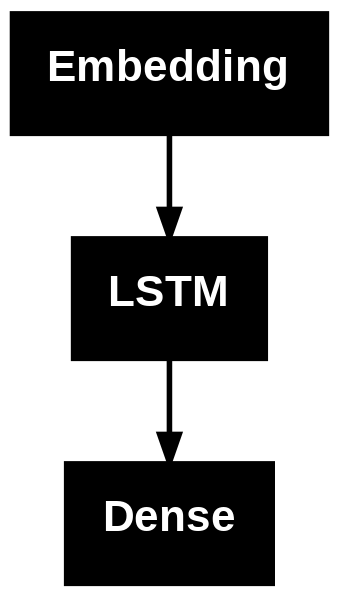

In [42]:
plot_model(model)

## Model evaluation

In [43]:
# y_pred = model.predict_classes(X_test)

# Let's make some predictions on the test dataset
y_pred = (model.predict(X_test) > 0.5).astype("int32")

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [44]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred) # ~91% accuracy 🤩

0.9225439247710963

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1914,  175],
       [ 138, 1814]])

In [46]:
embed_input.shape, y.shape

((20203, 356), (20203,))

In [47]:
model.evaluate(embed_input, y) # will fail

ValueError: Cannot take the length of shape with unknown rank.

In [48]:
model.evaluate(X_final, y_final) # Wow, ~98% accuracy on the entire dataset (but it also includes training set, so don't take it too seriously)

632/632 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9846 - loss: 0.1177


[0.11537839472293854, 0.9845072627067566]